Tensorflow

In [1]:
import cv2 as cv
import numpy as np

# Set your parameters directly
input_image_path = "test1.jpg"
output_image_path = "path/to/your/output/annotated_image.jpg"
thr = 0.2
inWidth = 368
inHeight = 368

BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
              ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
              ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]]

# Load network
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

# Read the image
frame = cv.imread(input_image_path)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]

# Prepare the frame to feed to the network
net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
out = net.forward()
out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

assert(len(BODY_PARTS) == out.shape[1])

points = []
for i in range(len(BODY_PARTS)):
    # Slice heatmap of corresponding body's part.
    heatMap = out[0, i, :, :]

    # Originally, we try to find all the local maximums. To simplify a sample
    # we just find a global one. However, only a single pose at the same time
    # could be detected this way.
    _, conf, _, point = cv.minMaxLoc(heatMap)
    x = (frameWidth * point[0]) / out.shape[3]
    y = (frameHeight * point[1]) / out.shape[2]
    # Add a point if its confidence is higher than the threshold.
    points.append((int(x), int(y)) if conf > thr else None)

for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)

    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]

    if points[idFrom] and points[idTo]:
        cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
        cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
        cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

t, _ = net.getPerfProfile()
freq = cv.getTickFrequency() / 1000
cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

# Save the annotated image
cv.imwrite(output_image_path, frame)
print(f"Annotated image saved as {output_image_path}")


Annotated image saved as path/to/your/output/annotated_image.jpg


Pytorch

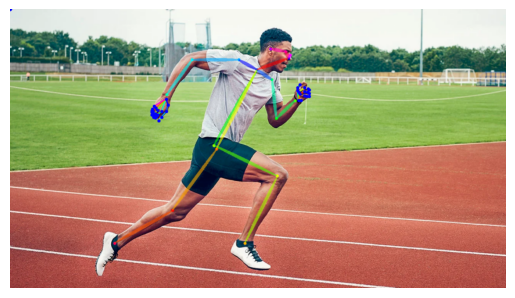

In [3]:
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np


from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('models/body_pose_model.pth')
hand_estimation = Hand('models/hand_pose_model.pth')

test_image = 'run_test1.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order
candidate, subset = body_estimation(oriImg)
canvas = copy.deepcopy(oriImg)
canvas = util.draw_bodypose(canvas, candidate, subset)
# detect hand
hands_list = util.handDetect(candidate, subset, oriImg)

all_hand_peaks = []
for x, y, w, is_left in hands_list:
    # cv2.rectangle(canvas, (x, y), (x+w, y+w), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    # cv2.putText(canvas, 'left' if is_left else 'right', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # if is_left:
        # plt.imshow(oriImg[y:y+w, x:x+w, :][:, :, [2, 1, 0]])
        # plt.show()
    peaks = hand_estimation(oriImg[y:y+w, x:x+w, :])
    peaks[:, 0] = np.where(peaks[:, 0]==0, peaks[:, 0], peaks[:, 0]+x)
    peaks[:, 1] = np.where(peaks[:, 1]==0, peaks[:, 1], peaks[:, 1]+y)
    # else:
    #     peaks = hand_estimation(cv2.flip(oriImg[y:y+w, x:x+w, :], 1))
    #     peaks[:, 0] = np.where(peaks[:, 0]==0, peaks[:, 0], w-peaks[:, 0]-1+x)
    #     peaks[:, 1] = np.where(peaks[:, 1]==0, peaks[:, 1], peaks[:, 1]+y)
    #     print(peaks)
    all_hand_peaks.append(peaks)

canvas = util.draw_handpose(canvas, all_hand_peaks)

plt.imshow(canvas[:, :, [2, 1, 0]])
plt.axis('off')
plt.show()

In [3]:
import pandas as pd
df = pd.read_csv('sports2D/run_test1_BLAZEPOSE_person0_angles.csv', header = 0) 

# Display DataFrame
print(df)

        scorer DavidPagnon       DavidPagnon.1        DavidPagnon.2  \
0  individuals     person0             person0              person0   
1         angs        Time         Right ankle           Left ankle   
2       coords     seconds        dorsiflexion         dorsiflexion   
3            0         0.0  0.6479293922088374  -30.548367940636794   

       DavidPagnon.3       DavidPagnon.4      DavidPagnon.5  \
0            person0             person0            person0   
1         Right knee           Left knee          Right hip   
2            flexion             flexion            flexion   
3  94.89738841617128  24.920837012220886  83.07641237841968   

         DavidPagnon.6      DavidPagnon.7      DavidPagnon.8  ...  \
0              person0            person0            person0  ...   
1             Left hip     Right shoulder      Left shoulder  ...   
2              flexion            flexion            flexion  ...   
3  -1.3517614197843386  -70.2188474064119  43.234247

In [2]:
import pandas as pd
df = pd.read_csv('sports2D/test1_BLAZEPOSE_person0_angles.csv', header = 0) 

# Display DataFrame
print(df)

        scorer DavidPagnon        DavidPagnon.1       DavidPagnon.2  \
0  individuals     person1              person1             person1   
1         angs        Time          Right ankle          Left ankle   
2       coords     seconds         dorsiflexion        dorsiflexion   
3            0         0.0  -12.813671558495145  -0.995712251439258   

       DavidPagnon.3      DavidPagnon.4      DavidPagnon.5  \
0            person1            person1            person1   
1         Right knee          Left knee          Right hip   
2            flexion            flexion            flexion   
3  44.83181977984134  73.83584747063753  87.71825179163127   

        DavidPagnon.6      DavidPagnon.7      DavidPagnon.8  ...  \
0             person1            person1            person1  ...   
1            Left hip     Right shoulder      Left shoulder  ...   
2             flexion            flexion            flexion  ...   
3  124.02040276036124  98.30511822612095  79.66074961827792  